In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
from SARA_cornell_funcs import *

# The following workflow allows me only to call on one lg-LSA processing condition at a time

## General workflow:
- Point to where the data is stored and generate condition/fp dictionary
- Use the class called TechStripe to process the technique map generation
- outputs of that class are easily called up on or can be stored into whatever you need (number or location of transformations, gradients, specific reflectance or diffraction patterns, etc.)

In [3]:
#an identifyer for saving data,etc.
MatSysName = 'test'

#A path to where the .bmp files are stored for image analysis. 
#the image mirror is not required, but can help with intensity normalization.
ptim = '/home/vandover/Documents/Data/20F19_CrOx_subOx/Images/2020-08-22/'
# ptImgMirror = '/path/to/image/illumination/mirror/file.bmp'

#A path to the raw spectroscopy data, the blank, and the mirrors. 
#There are far more mirrors and blanks than necessary, the script generating the spectroscopy maps
#just needs the filepath to one of them. 
ptsp_raw = '/home/vandover/Documents/Data/20F19_CrOx_subOx/Spectroscopy/2020-09-04/'
ptsp_m = '/home/vandover/Documents/Data/20F19_CrOx_subOx/Spectroscopy/2020-09-04/mirrors/mirror_00.csv'
ptsp_b = '/home/vandover/Documents/Data/20F19_CrOx_subOx/Spectroscopy/2020-09-04/blanks/blank_00.csv'

In [4]:
#Dictionary structure:
# Dictionary:
#     condtion key
#         [tau,T,xpos,ypos,fp]

# For the a-Si work, T is maximum power for a stripe
OptDict = FpDict(pathtofiles=ptim,ftype='.bmp')
SpecDict = FpDict(ptsp_raw,ftype='.csv')

# The TechStripe class:
## This is my way of calling on the 3 different techniques for a single condition, and being able to iterate through them all without eating up all my RAM.

The object gets instantiated and you can pass all the approrpriate file paths and techinique information into it. The three main techniques we used to compare our data were optical microscopy, spatially resloved spectroscopy, and spatially resolved XRD. The class is currently built to handle any number of these three techniques. The TechStripe class is located in the SARA_cornell_funcs.py library

In [29]:
key = list(OptDict)[-1] #some test case

stripe = TechStripe()

#the filepaths to the appropriate stripes and technique normalization data are called on here
stripe.fpo = OptDict[key]['fp']
# stripe.fpImM = ptImgMirror

stripe.fprs = SpecDict[key]['fp']
stripe.fpb = ptsp_b
stripe.fpm = ptsp_m

#Each technique esesentailly produces a 'map' of data. 
#The Y and intensity coordinates all vary, but they share a common spatial extent.
#It is important to make sure that the effective pixel size or technique resolution is recorded
#  - The pitch of most reflectance spectroscopy data are 10 um, this example uses 5 um
#  - the image pixel size depends on the magnification and needs the PSC. recent data are 0.808 um/pixel
stripe.O_pxs = 0.808
stripe.S_pxs = 5

#create optical and spectroscopy maps with the techstripe fucntions Optmap and Specmap
omap = stripe.Optmap(okey=key,weights=[0,0,1],grayscale=False,Norm=False,Average=True)
smap = stripe.Specmap(key,wlmax=800,wlmin=450,s_param=5)[2]

#The y-axis of the spectroscopy map is the wavelength of the reflected photon and can be defined here
#the valuable reflectance data is only within the 450-800 nm range. the signal to noise kills the other wavelenths
wl = stripe.wl

[False False False ... False False False]


## Generating gradients and defining the spatial extent

For a comparative study, we needed to make sure all data were spatially aligned and over the same extent. What is important here is defining the gradient of the images, appropriately appodizing the data,and using the pixel size and the center of the stripe to make technique data comparable.


Text(0, 0.5, 'wavelengthin  nm')

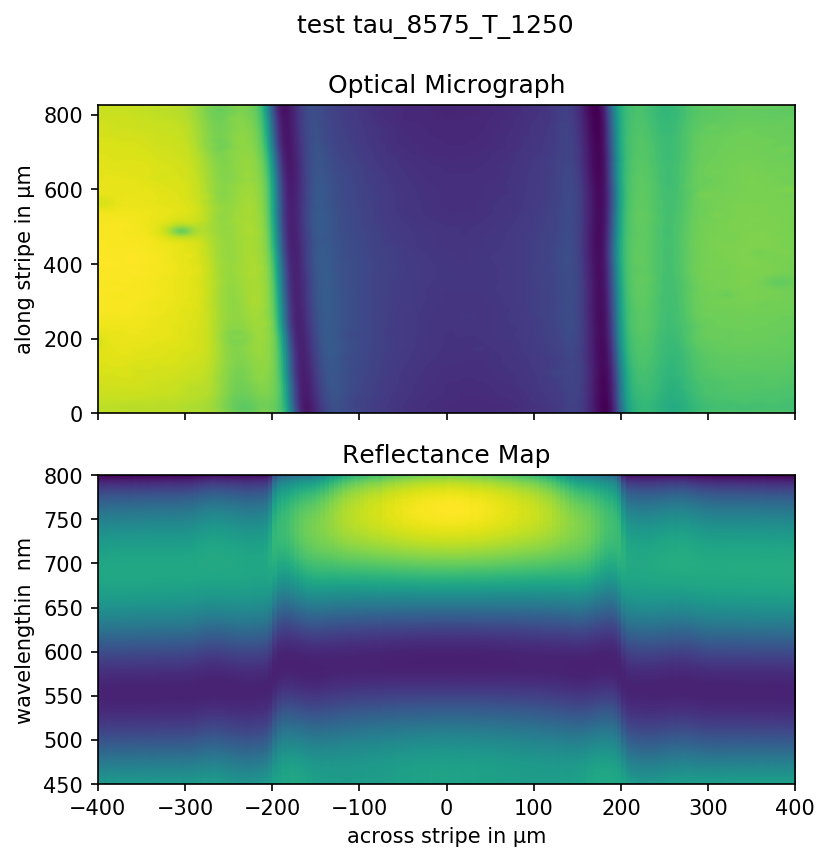

In [33]:
#filtering the omap to remove noise and calculating the gradient
omap = ndimage.gaussian_filter(omap,(5/stripe.O_pxs))
g = np.gradient(np.sum(omap,axis=0))
g = np.sqrt(g*g)
og = g/max(g)

#Defining the spatial extent
ox = np.linspace(0,omap.shape[1]*stripe.O_pxs,omap.shape[1])
sx = np.linspace(0,smap.shape[1]*stripe.S_pxs,smap.shape[1])

#The spectroscopy gradient
sg = Grad(smap,bound_avg=True,norm=True)[0]


#determining the center of each stripe through the gradient signals and setting the center to 0
ocenter = np.round(CenterFinding(og,sparam=2,plotting=False))
scenter = np.round(CenterFinding(sg,sparam=2,plotting=False))

ox = ox - ocenter*stripe.O_pxs
sx = sx - scenter*stripe.S_pxs

#Identifying the common spatial extent for each technique 
minx = np.max([np.min(ox),np.min(sx)])
maxx = np.min([np.max(ox),np.max(sx)])

#can also hard code it
minx,maxx = [-400,400]

ox1 = ox[(ox>=minx)&(ox<=maxx)]
sx1 = sx[(sx>=minx)&(sx<=maxx)]

osym = Symmetrize(og,ocenter,plotting=False)[(ox>=minx)&(ox<=maxx)]
ssym = Symmetrize(sg,scenter,plotting=False)[(sx>=minx)&(sx<=maxx)]

omap1 = omap[:,[(ox>=minx)&(ox<=maxx)][0]]
smap1 = smap[:,[(sx>=minx)&(sx<=maxx)][0]]

#Test plotting the gradients along thier spatial extent
# fig,ax = plt.subplots(2,1,dpi=150)
# ax[0].plot(ox1,osym)
# ax[1].plot(sx1,ssym)
# plt.show()
# plt.close()

#plotting the maps comparatively along the stripes
fig,ax = plt.subplots(2,1,dpi=150,figsize=(6,6),sharex=True)
fig.suptitle(f'{MatSysName} {key}')
ax[0].set_title('Optical Micrograph')
ax[1].set_title('Reflectance Map')
ax[0].imshow(omap1,aspect='auto',extent=[minx,maxx,0,omap1.shape[0]*stripe.O_pxs])
ax[1].imshow(smap1,aspect='auto',extent=[minx,maxx,wl[0],wl[-1]])

# ax[0].set_xlabel('across stripe in \u03BCm')
ax[1].set_xlabel('across stripe in \u03BCm')
ax[0].set_ylabel('along stripe in \u03BCm')
ax[1].set_ylabel('wavelengthin  nm')

# Transition finding

Once the maps are along the same spatial extent and aligned, you can do further transformation analysis. This involves looking at the peaks and widths of the transformations in each technique. There is opportunity to try an use the Temperature profile on hand, but don't necessarily trust the results. 


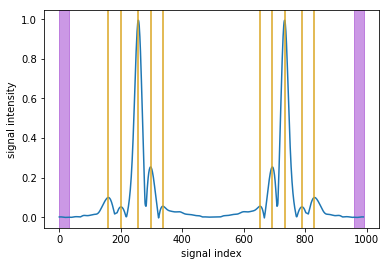

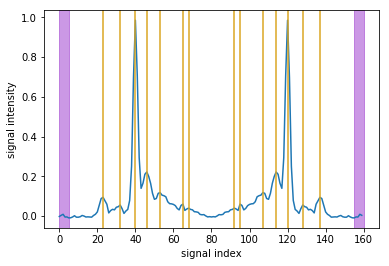

Text(0, 0.5, 'wavelengthin  nm')

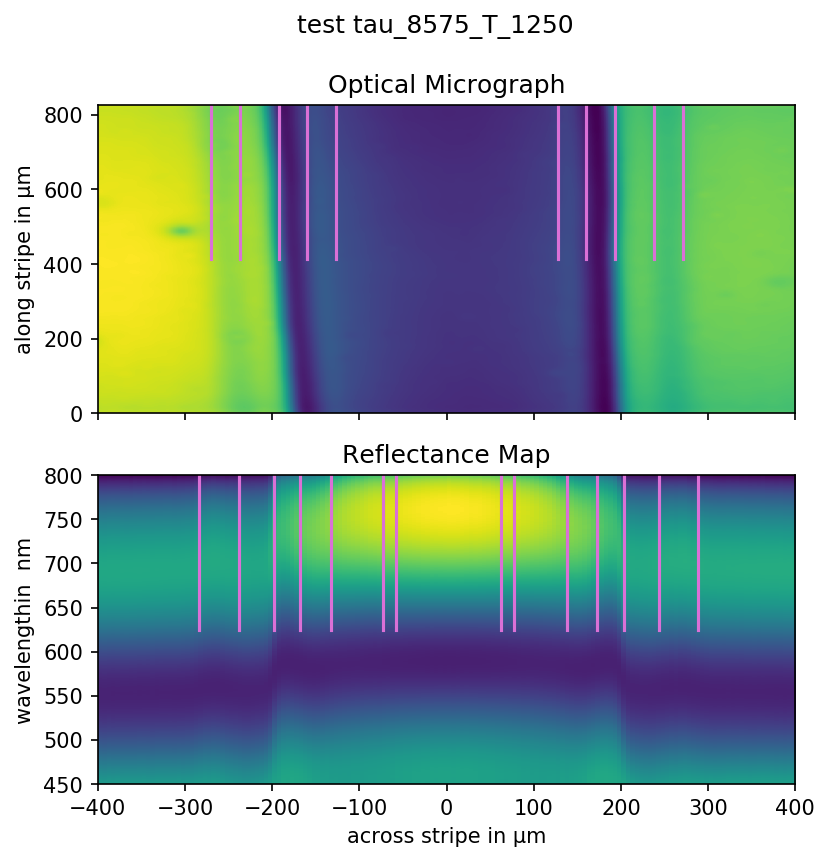

In [40]:
otrs,otrs_peakdeets = TransitionFinder(data=osym,prom_filt=0.01,bkgd_ROI=[30,-30],plotting=True)
strs,strs_peakdeets = TransitionFinder(data=ssym,prom_filt=0.01,bkgd_ROI=[5,-5],plotting=True)

#plotting the maps comparatively along the stripes
fig,ax = plt.subplots(2,1,dpi=150,figsize=(6,6),sharex=True)
fig.suptitle(f'{MatSysName} {key}')
ax[0].set_title('Optical Micrograph')
ax[1].set_title('Reflectance Map')
ax[0].imshow(omap1,aspect='auto',extent=[minx,maxx,0,omap1.shape[0]*stripe.O_pxs])
ax[1].imshow(smap1,aspect='auto',extent=[minx,maxx,wl[0],wl[-1]])

for tr in otrs:
    ax[0].axvline(ox1[tr],ymin=0.5,ymax=1,c='orchid')

for tr in strs:
    ax[1].axvline(sx1[tr],ymin=0.5,ymax=1,c='orchid')


# ax[0].set_xlabel('across stripe in \u03BCm')
ax[1].set_xlabel('across stripe in \u03BCm')
ax[0].set_ylabel('along stripe in \u03BCm')
ax[1].set_ylabel('wavelengthin  nm')